In [1]:
import pandas as pd


from dbfread import DBF
from pandas import DataFrame

#reading excel data that contains time series data:
df2 = pd.read_excel("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\ID5ZonalMeanSandAdj\\ID5SandAdjMean.xlsx")
#dbf = DBF("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf", load=True)
#dbf = DBF("D:\\LCL\\LCL\\yaping coral reef\\ShpData\\ShpData\\ValidLocationsMean.dbf", load=True)
#df = DataFrame(iter(dbf))

#from simpledbf import Dbf5
# dbf = Dbf5("C:\\Users\\LCL\\Allen Coral Atlas\\ShpData\\ValidLocationsMax.dbf")

#import geopandas as gpd
#gpddf = gpd.read_file("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf",float_precision='high') 
#df=pd.DataFrame(gpddf)


#df1 = gpd.GeoDataFrame.from_file(u"C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf")
#df = pd.DataFrame(df1)

##df = dbf.to_dataframe()
#df


In [2]:
import sys
'geopandas' in sys.modules

False

In [3]:
df2.head()

,Id,ds,y
0,1,20190729,0.0353
1,2,20190805,0.0434
2,3,20190812,0.0417
3,4,20190819,0.0618
4,5,20190826,0.0499


In [4]:
len(df2)

15

In [8]:
import pandas as pd
from fbprophet import Prophet
import matplotlib
import altair as alt
alt.renderers.enable('notebook')
from vega_datasets import data #the last three lines are for plotting support

from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=110000), to_values) # default is 5000 rows, changed to 110000 to display total rows.
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

#df1 = pd.read_excel("C:\\Users\\yapingxu\\Documents\\TimeSeriesPython\\Oahu\\DataCSV - Copy.xlsx")
#The following modual is to define the forcasting model.Seasonality, interval_width and number of change points are the three most important parameters.
def fit_predict_model(dataframe, interval_width = 0.90, n_changepoints =4):
    # fit the model by instantiating a new Prophet object:
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                n_changepoints = n_changepoints
                )
                #optional parameter:changepoint_range = changepoint_range)
    # then call its fit method and pass in the historical dataframe:    
    m = m.fit(dataframe) 
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    forecast['Id'] = dataframe['Id']
    ##The predict method will assign each row in future a predicted value which it names yhat. 
    # we pass in historical dates by the above fit method, it will provide an in-sample fit. 
    #The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals. They'll be used in the next module.
    return forecast
    
pred = fit_predict_model(df2)

INFO:fbprophet:n_changepoints greater than number of observations.Using 9.


In [9]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact','Id']].copy() #see the lat comment in the last module.
    #forecast['fact'] = df['y']
    
    # define the anomalies records. If the true value is larger than predicted upper, it's defined as upper anomaly. If the true value is smaller than predicted lower, it's defined as lower anomaly. 
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances, define the size of the red points.
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred2 = detect_anomalies(pred)

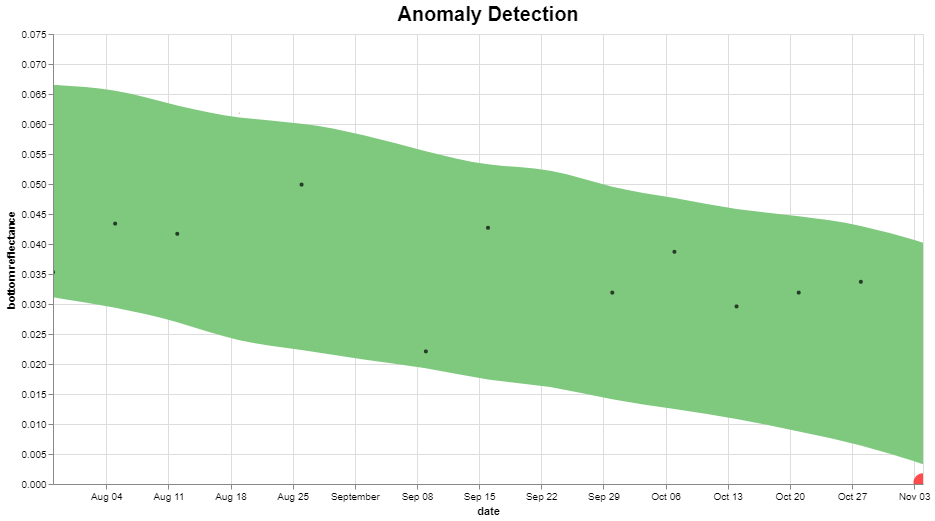

In [10]:
def plot_anomalies(forecasted):
    # define how to plot the background with upper and lower boundary:
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id']
    ).interactive().properties(
        title='Anomaly Detection'
    )
    # define how to plot the "normal" values, and interactively show them up as mouse pointer hovers over them.
    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='bottom reflectance'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id']
    ).interactive()
    # define how to plot the anomaly values, and show them up as mouse pointer hovers over them.
    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='bottom reflectance'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
            
plot_anomalies(pred2)

In [20]:
print (pred.Id) #for testing purpose, can be ignored.

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [21]:
print (pred2.Id) #for testing purpose, can be ignored.

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [22]:
print (pred.Id) #for testing purpose, can be ignored.

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [23]:
upper = pred[pred['fact']>pred['yhat_upper']] 
lower = pred[pred['fact']<pred['yhat_lower']] 
#abnorm=pred[pred['anomaly']==0]

In [24]:
print (upper)

Empty DataFrame
Columns: [ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat, fact, Id]
Index: []


In [25]:
#Output the anmaly results into table:
from IPython.core.display import HTML
display(HTML(upper.to_html()))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact,Id
